In [1]:
# pip install meshio

In [2]:
from FoldModellingPlugin.FoldModellingPlugin.optimisers import FourierSeriesOptimiser as FSO
from FoldModellingPlugin.FoldModellingPlugin.helper.utils import create_fold_frame_dataset
from LoopStructural import GeologicalModel
from LoopStructural.modelling.features.fold import FoldEvent
# from LoopStructural.visualisation import LavaVuModelViewer
# from custom_model_visualisation import LavaVuModelViewer
from LoopStructural.visualisation import MapView
from LoopStructural.visualisation import RotationAnglePlotter
from LoopStructural.modelling.features.fold import FoldRotationAngle, SVariogram
from LoopStructural.modelling.features import StructuralFrame, GeologicalFeature
from LoopStructural.modelling.features.fold import fourier_series
from LoopStructural.utils.helper import create_surface, create_box, get_data_bounding_box, normal_vector_to_strike_and_dip, plunge_and_plunge_dir_to_vector
import os
import time
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import IntProgress

ERROR: 2023-10-11 10:41:42,719: __init__.py:21 -- Cannot use sphinx scraper, pip install -r docs/requirements.txt
ERROR: 2023-10-11 10:41:42,723: __init__.py:25 -- Missing lavavu, can't import LavaVuModelViewer


# I. Creation of a synthetic model

1. Define model bounding box

In [3]:
# define the naximum value of xyz model box boundaries
xmin = 0
ymin = 0
zmin = 0
xmax = 1000
ymax = 1000
zmax = 1000
bounding_box = np.array([[xmin, ymin, zmin],
               [xmax, ymax, zmax]])

2. Initialise a geological model 

In [4]:
# initiliase geological model by initialising GeologicalModel class
model = GeologicalModel(bounding_box[0, :], 
                        bounding_box[1, :])

3. Build a fold frame

In [5]:
# Create a dataset for s1 to build a fold frame 
dataset, xyz = create_fold_frame_dataset(model, strike=0, dip=90)
# add data to the initiliased geological model
model.data = dataset

In [6]:
# build the s1 fold frame
s1 = model.create_and_add_fold_frame('s1',
                                          buffer=0.3,
                                          solver='pyamg',
                                          nelements=2e4,
                                        damp=True)
model.update()

ERROR: 2023-10-11 10:41:43,761: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-10-11 10:41:43,762: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-10-11 10:41:43,762: _base_geological_feature.py:73 -- Model not set


Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region


  0%|          | 0/3 [00:00<?, ?it/s]

ERROR: 2023-10-11 10:42:05,574: _geological_feature_builder.py:213 -- Not enough constraints for scalar field add more


In [7]:
s1[1].evaluate_gradient(xyz)

array([[ 6.40723899e-08, -1.00000002e+00, -1.93466567e-08],
       [ 8.13423424e-08, -1.00000001e+00,  4.61577354e-09],
       [ 6.50102605e-09, -9.99999984e-01,  1.25199353e-08],
       ...,
       [-7.47955127e-08, -1.00000007e+00,  2.21790740e-07],
       [-5.59494906e-08, -9.99999958e-01,  3.16145519e-07],
       [ 2.94218303e-08, -9.99999934e-01,  1.95581184e-07]])

In [8]:
# # 3D displaying the s1 fold frame
# # import lavavu
# viewer = LavaVuModelViewer(model, background='white')
# viewer.add_isosurface(s1[0], colour='red')
# viewer.add_isosurface(s1[1], colour='blue')
# viewer.add_data(s1[0], disks=False, vectors=True, colour='red')
# viewer.add_data(s1[1], disks=False, vectors=True, colour='blue')
# # t = viewer.add_scalar_field(s1[0], cmap='prism')
# # viewer.lv.colourbar(t, align=("bottom"))
# viewer.lv.rotate([-63.015506744384766, -24.475210189819336, -8.501092910766602])
# viewer.display()
# viewer.interactive()

4. Define the fold limb rotation angle profile

In [9]:
def fold_limb_rotation_profile(c0, c1, c2, wl):

    theta = [c0, c1, c2, wl]
    x = np.linspace(s1[0].min(), s1[0].max(), 100)
    flr = np.rad2deg(np.arctan(fourier_series(x, *theta)))
    # fold_limb_rotation = FoldRotationAngle(flr, x) 
    # fold_limb_rotation.fitted_params = theta
    # fold_limb_rotation.set_function(lambda x: np.rad2deg(
    #                 np.arctan(fourier_series(x, *theta))))
    plt.ylim(-90, 90)
    plt.xlabel('Fold Axial Surface Field')
    plt.ylabel('Fold Limb Rotation Angle')
    plt.title('Fold Limb S-Plot')
    plt.plot(x, flr)
    plt.show()
    
    return flr, x

def define_fold_axis_orientation(plunge_direction, plunge): 
    
    fold_axis = plunge_and_plunge_dir_to_vector(plunge, plunge_direction)
    
    return fold_axis

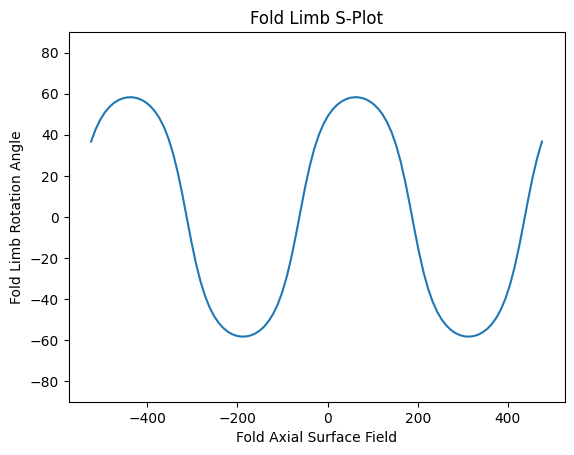

In [10]:
theta = [0, 2e-2, 2e-2, 500]
fold_limb_rotation, x = fold_limb_rotation_profile(*theta)

In [11]:
np.random.seed(180)
n = np.arange(len(x))
sample_size = 10
indices = np.random.choice(n, sample_size, replace=False)
flr = fold_limb_rotation[indices]
fld = x[indices]

In [12]:
geological_knowledge = { 
    'fold_limb_rotation_angle': {
        'tightness': {'mu':60, 'sigma':10, 'w':1},
        'asymmetry': {'mu':0, 'sigma':0.1, 'w':1},
        # 'fold_wavelength': {'mu':500, 'sigma':50, 'w':1},
    }
} 

In [13]:
fourier_optimiser = FSO(fld, flr, x, method='differential_evolution')

In [14]:
opt = fourier_optimiser.optimise(geological_knowledge=geological_knowledge)

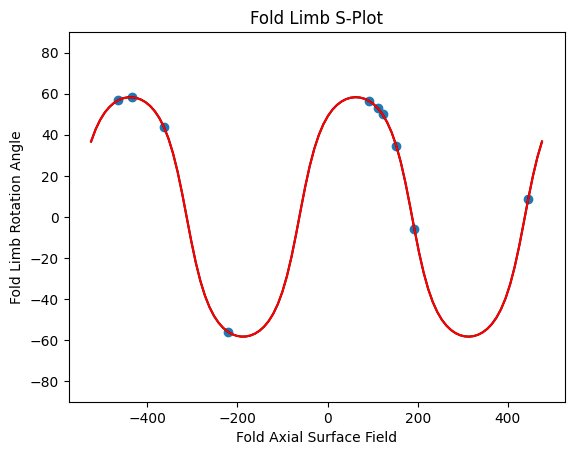

In [15]:
plt.ylim(-90, 90)
plt.xlabel('Fold Axial Surface Field')
plt.ylabel('Fold Limb Rotation Angle')
plt.title('Fold Limb S-Plot')
plt.plot(x, fold_limb_rotation, color='black')
plt.plot(x, np.rad2deg(np.arctan(fourier_series(x, *opt.x))), color='red')
plt.scatter(fld, flr)
plt.show()

In [61]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Initial dictionary structure
dict_structure = {
    'fold_limb_rotation_angle': {},
    'fold_axis_rotation_angle': {},
    'fold_axial_surface': {}
}

# def create_value_widgets():
#     return {
#         'mu': widgets.FloatText(value=0, description='mu'),
#         'sigma': widgets.FloatText(value=0, description='sigma'),
#         'w': widgets.FloatText(value=1, description='w')
#     }
def create_mu_widgets():
    mu_widgets = [
        widgets.FloatText(value=0, description=f'mu[{i}]') for i in range(3)
    ]
    return widgets.HBox(mu_widgets)

axial_surface_mu = create_mu_widgets()
def create_value_widgets():
    selected_constraint = constraint_dropdown.value
    selected_sub_constraint = sub_constraint_dropdown.value
    if selected_constraint == 'fold_axial_surface' and selected_sub_constraint == 'axial_surface':
        mu_widget = create_mu_widgets()
        return {
        'mu': mu_widget,
        'kappa': widgets.FloatText(value=5, description='kappa'),
        'w': widgets.FloatText(value=1, description='w')
    }
    else:
        mu_widget = widgets.FloatText(value=10, description='mu')
    return {
        'mu': mu_widget,
        'sigma': widgets.FloatText(value=10, description='sigma'),
        'w': widgets.FloatText(value=1, description='w')
    }

# def on_add_button_click(button):
#     selected_constraint = constraint_dropdown.value
#     selected_sub_constraint = sub_constraint_dropdown.value
#     values = {k: v.value for k, v in value_widgets.items()}
#     dict_structure[selected_constraint][selected_sub_constraint] = values
#     with output:
#         clear_output()
#         print(dict_structure)

def on_add_button_click(button):
    selected_constraint = constraint_dropdown.value
    selected_sub_constraint = sub_constraint_dropdown.value
    values = {}
    for k, v in value_widgets.items():
        if isinstance(v, widgets.HBox):
            # Assuming mu is the only HBox and is always composed of three FloatText widgets
            values[k] = [w.value for w in v.children]
        else:
            values[k] = v.value
    dict_structure[selected_constraint][selected_sub_constraint] = values
    with output:
        clear_output()
        print(dict_structure)

def on_constraint_change(change):
    new_value = change.get('new', None)
    sub_constraint_dropdown.options = sub_constraints.get(new_value, [])
    # Only call on_sub_constraint_change if form is defined
    if 'form' in globals():
        on_sub_constraint_change({'new': sub_constraint_dropdown.value})

def on_sub_constraint_change(change):
    global value_widgets
    value_widgets = create_value_widgets()
    form.children = [constraint_dropdown, sub_constraint_dropdown] + list(value_widgets.values()) + [add_button, output]

# Mapping of Major Constraints to their sub-constraints
sub_constraints = {
    'fold_limb_rotation_angle': ['tightness', 'asymmetry', 'fold_wavelength', 'axial_trace_1', 'axial_traces_2', 'axial_traces_3', 'axial_traces_4'],
    # ... (similar mappings for other Major Constraints)
    'fold_axis_rotation_angle': ['hinge_angle', 'fold_axis_wavelength'],
    'fold_axial_surface': ['axial_surface'],
}

def display_dict_selection():
    # Dropdown for constraints
    constraint_dropdown = widgets.Dropdown(options=list(sub_constraints.keys()), description='Major Constraint:')
    constraint_dropdown.observe(on_constraint_change, names='value')
    
    # Dropdown for sub-constraints
    sub_constraint_dropdown = widgets.Dropdown(description='Sub-Constraint:')
    sub_constraint_dropdown.observe(on_sub_constraint_change, names='value')
    
    # Button to add the details
    add_button = widgets.Button(description="Add Details")
    add_button.on_click(on_add_button_click)
    
    # Output widget to display the generated dictionary
    output = widgets.Output()
    
    # Initial value widgets
    value_widgets = create_value_widgets()
    
    # Form to hold all the widgets
    form = widgets.VBox([constraint_dropdown, sub_constraint_dropdown] + list(value_widgets.values()) + [add_button, output])
    
    # Initial setup
    on_constraint_change({'new': constraint_dropdown.value})
    
    display(form)

